# 07. 시간의존 공변량 (콕스비례위험모형의 확장)
- **콕스비례위험모형 (Cox proportional hazard(PH) model)의 중요한 가정 : 연구가 시작될 때 공변량이 결정되며, 시간이 지나도 공변량은 변하지 않는다는 것**
- **하지만 특정경우 시간에 따라 변동 가능 => 시간의존공변량(time-dependent covariate)**
    - **중간사건 (intermediate event) : 연구 기간 동안 그 발생 여부가 서로 다르며, 발생 시점 또한 다름**
    - 예 : 백혈병 환자의 사망시점이 반응변수일 때, 골수이식과 같은 중간사건(intermediate event)의 발생여부는 사망시간을 예측하는 데 매우 중요한 영향

# 
# 
### 7-1 심장이식 연구 예제
#### 시간의존공변량을 다룰 때 주의점 : 미래의 공변량 값으로 생존을 예측할 수 없음 

In [3]:
library(survival)
library(tidyverse)
library(flextable)
library(autoReg)

In [4]:
data(heart, package = "survival")

# 
- ```transplant``` : 심장이식 여부 (심장이식을 받은경우 1)
    - ```transplant```의 위험률은 0.18이며, p-value < 0.05 => ```transplant```가 환자의 수명을 늘리는데 매우 효과적

In [6]:
gaze(fit) %>% myft()

a flextable object.
col_keys: ` `, `coef`, `se(coef)`, `z`, `Pr(>|z|)`, `HR`, `lower`, `upper` 
header has 1 row(s) 
body has 3 row(s) 
original dataset sample: 
—————————————————————————————————————————————————————————————————————
                coef  se(coef)       z  Pr(>|z|)     HR  lower  upper 
—————————————————————————————————————————————————————————————————————
transplant    -1.717     0.279  -6.165     <.001  0.180  0.104  0.310 
age            0.059     0.015   3.913     <.001  1.061  1.030  1.092 
surgery       -0.419     0.371  -1.129      .259  0.658  0.318  1.361 
—————————————————————————————————————————————————————————————————————
n=103, events=75, Likelihood ratio test=45.85 on 3 df (p<.001) 

# 
### 하지만, ```transplant```가 시간에 따라하는 공변량 => 환자가 심장이식을 받기 위해서는 심장이식을 받을 수 있을만큼  오래 살아야 함
### 따라서, 오래산 환자가 오래 살지 못한 환자에 비해 오래 살았다는 것을 보여준 것에 지나지 않음 (항진명제 (tautology))

# 
#### 이러한 문제에 대한 해결방법 : 랜드마크 시간을 정해 환자를 두 군으로 나누는 것
- 랜드마크 시간 전에 심장이식을 받은 환자들을 환자군으로 하고, 심장이식을 받지 못한 환자들을 대조군으로 설정

# 

#### 랜드마크 시간까지 생존한 환자들만 연구에 포함시키고, 모든 환자들(특히 대조군)은 랜드마크 시간 이후에 이식을 받더라도 대조군에 계속 남아있어야 함
- 예 : 랜드마크 시간 = 30
    1. 최소 30일 이상 생존한 환자들 선정 (103명중 79명)
    2. 79명 중 33명이 30일 이내에 심장이식을 받았으며, **46명은 30일 이내에 받지 못함**
    3. **46명 중 30명은 이후 심장이식을 받았으나, 여전히 30일 전에 심장이식을 받지 못한 환자로 분류**

# 
- ```transplant30```의 위험률은 0.96, p-value > 0.05 => 통계적으로 유의하지 않음 

#### 즉, 30일 이상 생존한 환자들에 대해서는 심장이식이 생존률에 영향을 주지 않음

**랜드마크 분석결과 심장이식을 받은 환자와 받지 않은 환자 간의 생존차이는 없음**
(랜드마크 기간 설정에 대해서는 명확한 방법은 없음)

In [14]:
ind30 = jasa$futime >= 30 # 30일 이상 생존한 환자

transplant30 = (jasa$transplant==1) & (jasa$wait.time < 30) # 30일 이후 심장수술을 받았는지의 여부

fit1 = coxph(Surv(futime, fustat) ~ transplant30 + age + surgery, jasa, subset = ind30)
gaze(fit1) %>% myft()

a flextable object.
col_keys: ` `, `coef`, `se(coef)`, `z`, `Pr(>|z|)`, `HR`, `lower`, `upper` 
header has 1 row(s) 
body has 3 row(s) 
original dataset sample: 
———————————————————————————————————————————————————————————————————————————
                      coef  se(coef)       z  Pr(>|z|)     HR  lower  upper 
———————————————————————————————————————————————————————————————————————————
transplant30TRUE    -0.042     0.284  -0.148      .882  0.959  0.550  1.672 
age                  0.037     0.017   2.170      .030  1.038  1.004  1.073 
surgery             -0.820     0.413  -1.985      .047  0.441  0.196  0.990 
———————————————————————————————————————————————————————————————————————————
n=79, events=52, Likelihood ratio test=9.5 on 3 df (p=.023) 

# 
#### 랜드마크 분석 이외에는, ```transplant```를 시간의존공변량으로 사용
- 전통적인 콕스비례위험모형의 틀 안에서 분석이 가능하지만, **편향되지 않는 추정량을 얻기 위해 자료를 변형해야함**

# 
#### 데이터 변형 방법 :
- 심장이식을 받은 환자의 타임라인은 이식받기 전과 이식받은 후의 두 시기로 구분
# 
원 데이터

In [29]:
jasa %>% mutate(id = row_number()) %>% .[c(2, 5, 10 ,12 ,28, 95), ] %>% select(id, wait.time, futime, fustat, transplant)

,id,wait.time,futime,fustat,transplant
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
2,2,NA,5,1,0
5,5,NA,17,1,0
10,10,11,57,1,1
12,12,NA,7,1,0
28,28,70,71,1,1
95,95,1,15,1,1


변형 후 데이터 **(start-stop 형식)**

In [31]:
jasa1 %>% select(id, start, stop, event, transplant) %>% filter(id %in% c(2, 5, 10 ,12 ,28, 95) )

id,start,stop,event,transplant
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,0,5,1,0
5,0,17,1,0
10,0,11,0,0
10,11,57,1,1
12,0,7,1,0
28,0,70,0,0
28,70,71,1,1
95,0,1,0,0
95,1,15,1,1


# 
변형된 최종데이터에 대한 분석
- **심장이식이 생존을 증가시킨다는 통계적 근거는 없음**
#### 랜드마크 분석과 같지만, 데이터의 손실이 없음

In [38]:
fit2 = coxph(Surv(start, stop, event) ~ transplant + surgery + age, jasa1)
gaze(fit2) %>% myft()

a flextable object.
col_keys: ` `, `coef`, `se(coef)`, `z`, `Pr(>|z|)`, `HR`, `lower`, `upper` 
header has 1 row(s) 
body has 3 row(s) 
original dataset sample: 
—————————————————————————————————————————————————————————————————————
                coef  se(coef)       z  Pr(>|z|)     HR  lower  upper 
—————————————————————————————————————————————————————————————————————
transplant     0.014     0.308   0.046      .964  1.014  0.554  1.856 
surgery       -0.773     0.360  -2.150      .032  0.462  0.228  0.934 
age            0.031     0.014   2.199      .028  1.031  1.003  1.059 
—————————————————————————————————————————————————————————————————————
n=170, events=75, Likelihood ratio test=10.72 on 3 df (p=.013) 

# 
#### 시간의존공변량이 있는 경우, $k$번째 subject의 시간 $t_i$의 공변량을 $Z_k (t_i)$라고 할 때, 위험함수를 $h(t) = h_0(t)e^{Z_k (t_i) \beta}$라고 할 수 있으며, 이 때의 부분가능도함수는
### $L(\beta) = \Pi^D_{i = 1} {{e^{z_i (t_i) \beta}}\over{\sum_{k \in R_i} e^{z_k (t_i) \beta}}}$

In [39]:
jasa %>% mutate(id = row_number()) %>% .[c(2, 5, 10 ,12 ,28, 95), ] %>% select(id, wait.time, futime, fustat, transplant)

,id,wait.time,futime,fustat,transplant
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
2,2,NA,5,1,0
5,5,NA,17,1,0
10,10,11,57,1,1
12,12,NA,7,1,0
28,28,70,71,1,1
95,95,1,15,1,1


#### $z_i(t)$ : t시점에 심장이식을 받았는지의 여부
# 

| $subject(i)$ | $event$ | $z_i(5)$ | $z_i(7)$ |  $z_i(15)$ | $z_i(17)$ | $z_i(57)$ | $z_i(71)$ |
| - | - | - | - | - | - | - | - |
| $2$ | $5$ | $0$ | | | | | |
| $5$ | $17$ | $0$ | $0$ | $0$ | $0$ | | |
| $10$ | $57$ | $0$ | $0$ |$1$ | $1$| $1$| |
| $12$ | $7$ | $0$ | $0$| | | | |
| $28$ | $71$ | $0$ | $0$ |$0$ |$0$ |$0$ |$1$ |
| $95$ | $15$ | $1$ |$1$ |$1$ | | | |

# 
#### 가장먼저 이벤트가 발생한 t=5에 patient at risk는 6명, 이중 심장이식을 바은 환자는 95번 환자 1명
#### 따라서, t=5에서의 부분가능도함수 :
### $ = {{e^{z_2 (5)\beta}}\over{e^{z_2 (5)\beta} + e^{z_5 (5)\beta}+ e^{z_10 (5)\beta}+ e^{z_12 (5)\beta}+ e^{z_28 (5)\beta}+ e^{z_{95} (5)\beta}}} = {{1}\over{5+e^{\beta}}}$

# 
#### 전체 부분가능도함수 : 
### $L(\beta) = {{1}\over{5+e^{\beta}}}\times{{1}\over{4+e^{\beta}}}\times{{1}\over{2+2e^{\beta}}}\times{{1}\over{2+e^{\beta}}}\times{{e^{\beta}}\over{1+e^{\beta}}}\times{{e^{\beta}}\over{e^{\beta}}}$

# 
# 
### 7-2 예측 가능한 시간의존변수
#### time transfer

# 
- 가능도비검정 : p-value > 0.05 => ```stagen```에 따른 차이는 거의 없음

In [51]:
data(pancreatic2, package = "asaur")
pancreatic2$stagen = ifelse(pancreatic2$stage =="M", 1, 0)
(fit = coxph(Surv(pfs, status) ~ stagen, data = pancreatic2))

Call:
coxph(formula = Surv(pfs, status) ~ stagen, data = pancreatic2)

         coef exp(coef) se(coef)    z     p
stagen 0.5931    1.8095   0.4007 1.48 0.139

Likelihood ratio test=2.43  on 1 df, p=0.1188
n= 41, number of events= 41 

- 비례위험 가정 점검 : p-value > 0.05 => 반응변수와 비례위험 가정 성립X => 시간에 따른 위험률이 일정하지 않음

In [52]:
cox.zph(fit)

       chisq df     p
stagen  4.52  1 0.034
GLOBAL  4.52  1 0.034

# 
#### 위험률의 변화를 $g(t) = z \times log(t)$로 가정
- **시간의존함수에 대한 p-value > 0.05이지만, 가능도비검정의 p-value < 0.05 => ```stage```와 시간의존함수의 조합은 차이가 있다는 근거**

In [54]:
(fit2 = coxph(Surv(pfs, status) ~ stage + tt(stagen), tt = function(x, t, ...) x * log(t), data = pancreatic2))

Call:
coxph(formula = Surv(pfs, status) ~ stage + tt(stagen), data = pancreatic2, 
    tt = function(x, t, ...) x * log(t))

               coef exp(coef) se(coef)      z      p
stageM       6.0096  407.3394   3.0598  1.964 0.0495
tt(stagen)  -1.0858    0.3376   0.5889 -1.844 0.0652

Likelihood ratio test=6.33  on 2 df, p=0.04229
n= 41, number of events= 41 

# 
Schoenfeld 잔차그림 & 시간의존함수 시각화
- 빨간선은 time transfer 함수의 적합선, 전체적인 로그 위험률이 시간에 따라 감소함을 나타냄

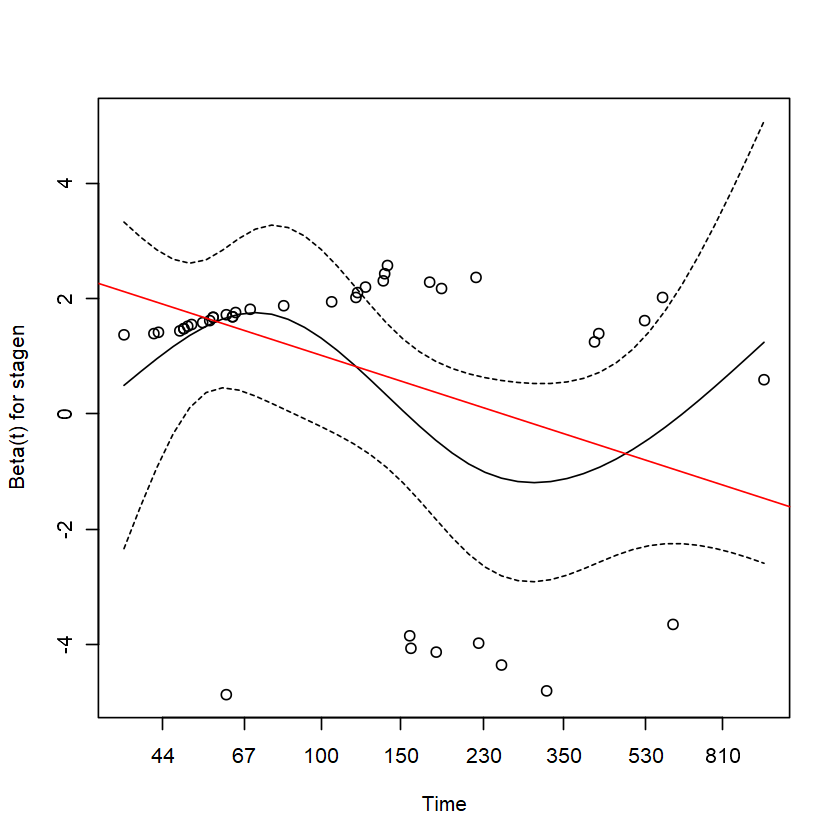

In [58]:
plot(cox.zph(fit, transform = function(pfs) log(pfs)))
abline(coef(fit2), col = "red")

# 
#### 다른 시간의존함수 
#### 시간전달함수 : $g(t) = z \times t$ 사용시
- 가능도비검정 결과 : p-value > 0.05 => 유의하지 않음

In [60]:
coxph(Surv(pfs, status) ~ stage + tt(stagen), tt = function(x, t, ...) x * t, pancreatic2)

Call:
coxph(formula = Surv(pfs, status) ~ stage + tt(stagen), data = pancreatic2, 
    tt = function(x, t, ...) x * t)

                coef exp(coef)  se(coef)      z      p
stageM      1.278099  3.589808  0.661027  1.934 0.0532
tt(stagen) -0.003656  0.996350  0.002532 -1.444 0.1487

Likelihood ratio test=4.56  on 2 df, p=0.1025
n= 41, number of events= 41 

### 실제 위험률의 변화에 잘 근사하는 위험률 함수를 찾아내는 것이 중요

# 
# 
#### 시간에 따라직선적으로 증가하는 시간의존변수
- 생존분석에서 연구시작 시의 환자나이를 공변량으로 사용하고, **이 값을 변화하지 않는 것으로 취급**

#### 하지만 시간이 지남에 따라 환자의 나이도 증가하는 것을 알고 있으므로, 환자의 나이를 시간의존변수로 처리해야 하는가?
- **=> YES, 하지만 나이를 시간의존변수로 처리하더라도 모형에는 변화가 없음**

# 
- ```age```가 증가함에 따라 로그 위험률이 증가함을 확인

In [66]:
coxph(Surv(time, status == 2) ~ age, lung)

Call:
coxph(formula = Surv(time, status == 2) ~ age, data = lung)

        coef exp(coef) se(coef)     z      p
age 0.018720  1.018897 0.009199 2.035 0.0419

Likelihood ratio test=4.24  on 1 df, p=0.03946
n= 228, number of events= 165 

- **나이는 연수(year), 생존시간은 일 수(day)로 되어있으므로, 생존시간도 연 단위로 변경**
    - 모형에 아무런 변화가 없음

In [67]:
coxph(Surv(time, status == 2) ~ tt(age), lung, tt = function(x, t, ...) {x + t / 365.25})

Call:
coxph(formula = Surv(time, status == 2) ~ tt(age), data = lung, 
    tt = function(x, t, ...) {
        x + t/365.25
    })

            coef exp(coef) se(coef)     z      p
tt(age) 0.018720  1.018897 0.009199 2.035 0.0419

Likelihood ratio test=4.24  on 1 df, p=0.03946
n= 228, number of events= 165 

# 
#### 왜 아무런 변화가 없을까?
- 연구가 시작할 때의 나이를 $z(0)$으로하고, 현재 나이를 $z(t) = z(0) + t$로하면 위험함수는 아래와 같음

### $h(t) = h_0(t) e^{\beta_z (t)} = h_0 (t) e^{\beta_t} \times e^{\beta_z (0)}$

# 
- 위 식을 부분가능도 식에 대입하면, 시간의존부분인 $e^{\beta_t}$가 분자 분모에 모두 있으므로, $z(0)$만 남음
- 따라서 시간의존모형의 회귀계수 $\beta$는 비시간의존모형의 회귀계수와 같게됨